
# Competitive Multi-Agent Reinforcement Learning (DDPG) with TorchRL Tutorial
**Author**: [Matteo Bettini](https://github.com/matteobettini)

.. seealso::
   The [BenchMARL](https://github.com/facebookresearch/BenchMARL)_ library provides state-of-the-art
   implementations of MARL algorithms using TorchRL.

This tutorial demonstrates how to use PyTorch and TorchRL to
solve a Competitive Multi-Agent Reinforcement Learning (MARL) problem.

For ease of use, this tutorial will follow the general structure of the already available :doc:`/tutorials/multiagent_ppo`.

In this tutorial, we will use the *simple_tag* environment from the
[MADDPG paper](https://arxiv.org/abs/1706.02275)_. This environment is part
of a set called [MultiAgentParticleEnvironments (MPE)](https://github.com/openai/multiagent-particle-envs)_
introduced with the paper.

There are currently multiple simulators providing MPE environments.
In this tutorial we show how to train this environment in TorchRL using either:

- [PettingZoo](https://pettingzoo.farama.org/)_, in the traditional CPU version of the environment;
- [VMAS](https://github.com/proroklab/VectorizedMultiAgentSimulator)_, which provides a vectorized implementation in PyTorch,
  able to simulate multiple environments on a GPU to speed up computation.

.. figure:: https://github.com/matteobettini/vmas-media/blob/main/media/scenarios/simple_tag.gif?raw=true
   :alt: Simple tag

   Multi-agent *simple_tag* scenario

Key learnings:

- How to use competitive multi-agent environments in TorchRL, how their specs work, and how they integrate with the library;
- How to use Parallel PettingZoo and VMAS environments with multiple agent groups in TorchRL;
- How to create different multi-agent network architectures in TorchRL (e.g., using parameter sharing, centralised critic)
- How we can use :class:`~tensordict.TensorDict` to carry multi-agent multi-group data;
- How we can tie all the library components (collectors, modules, replay buffers, and losses) in an off-policy multi-agent MADDPG/IDDPG training loop.


If you are running this in Google Colab, make sure you install the following dependencies:

```bash
!pip3 install torchrl
!pip3 install vmas
!pip3 install pettingzoo[mpe]==1.24.3
!pip3 install tqdm
```
Deep Deterministic Policy Gradient (DDPG) is an off-policy actor-critic algorithm
where a deterministic policy is optimised using the gradients from the critic network.
For more information, see the [Deep Deterministic Policy Gradients](https://arxiv.org/abs/1509.02971) paper.
This kind of algorithm is typically trained off-policy. For more info on off-policy learning see
*Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018*.

.. figure:: https://pytorch.s3.amazonaws.com/torchrl/github-artifacts/img/off-policy-vmas-loop-min.png
   :alt: Off-policy learning

   Off-policy learning

This approach has been extended to multi-agent learning in [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275)_,
which introduces the Multi Agent DDPG (MADDPG) algorithm.
In multi-agent settings, things are a bit different. We now have multiple policies $\mathbf{\pi}$,
one for each agent. Policies are typically local and decentralised. This means that
the policy for a single agent will output an action for that agent based only on its observation.
In the MARL literature, this is referred to as **decentralised execution**.
On the other hand, different formulations exist for the critic, mainly:

- In [MADDPG](https://arxiv.org/abs/1706.02275) the critic is centralised and takes as input the global state and global action
  of the system. The global state can be a global observation or simply the concatenation of the agents' observation.
  The global action is the concatenation of agent actions. MADDPG
  can be used in contexts where **centralised training** is performed as it needs access to global information.
- In IDDPG, the critic takes as input just the observation and action of one agent.
  This allows **decentralised training** as both the critic and the policy will only need local
  information to compute their outputs.

Centralised critics help overcome the non-stationary of multiple agents learning concurrently, but,
on the other hand, they may be impacted by their large input space.
In this tutorial, we will be able to train both formulations, and we will also discuss how
parameter-sharing (the practice of sharing the network parameters across the agents) impacts each.

The structure of this tutorial is as follows:

1. Initially, we will establish a set of hyperparameters for use.

2. Subsequently, we will construct a multi-agent environment, utilizing TorchRL's
   wrapper for either PettingZoo or VMAS.

3. Following that, we will formulate the policy and critic networks, discussing the effects of various choices on
   parameter sharing and critic centralization.

4. Afterwards, we will create the sampling collector and the replay buffer.

5. In the end, we will execute our training loop and examine the outcomes.

If you are operating this in Colab or on a machine with a GUI, you will also have the opportunity
to render and visualize your own trained policy before and after the training process.

Import our dependencies:




In [1]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

# Check if we're building the doc, in which case disable video rendering
try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False

## Define Hyperparameters

We set the hyperparameters for our tutorial.
Depending on the resources
available, one may choose to execute the policy and the simulator on GPU or on another
device.
You can tune some of these values to adjust the computational requirements.




In [2]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cuda")
)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 10  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# We will stop training the evaders after this many iterations,
# should be 0 <= iteration_when_stop_training_evaders <= n_iters
iteration_when_stop_training_evaders = n_iters // 2

# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network

## Environment

Multi-agent environments simulate multiple agents interacting with the world.
TorchRL API allows integrating various types of multi-agent environment flavors.
In this tutorial we will focus on environments where multiple agent groups interact in parallel.
That is: at every step all agents will get an observation and take an action synchronously.

Furthermore, the TorchRL MARL API allows to separate agents into groups. Each group will be a separate entry in the
tensordict. The data of agents within a group is stacked together. Therefore, by choosing how to group your agents,
you can decide which data is stacked/kept as separate entries.
The grouping strategy can be specified at construction in environments like VMAS and PettingZoo.
For more info on grouping, see :class:`~torchrl.envs.utils.MarlGroupMapType`.

In the *simple_tag* environment
there are two teams of agents: the chasers (or "adversaries") (red circles) and the evaders (or "agents") (green circles).
Chasers are rewarded for touching evaders (+10).
Upon a contact the team of chasers is collectively rewarded and the
evader touched is penalized with the same value (-10).
Evaders have higher speed and acceleration than chasers.
In the environment there are also obstacles (black circles).
Agents and obstacles are spawned according to a uniform random distribution.
Agents act in a 2D continuous world with drag and elastic collisions.
Their actions are 2D continuous forces which determine their acceleration.
Each agent observes its position,
velocity, relative positions to all other agents and obstacles, and velocities of evaders.

The PettingZoo and VMAS versions differ slightly in the reward functions as PettingZoo penalizes evaders for going
out-of-bounds, while VMAS impedes it physically. This is the reason why you will observe that in VMAS the rewards of the
two teams are identical, just with opposite sign, while in PettingZoo the evaders will have lower rewards.

We will now instantiate the environment.
For this tutorial, we will limit the episodes to ``max_steps``, after which the terminated flag is set. This is
functionality is already provided in the PettingZoo and VMAS simulators but the TorchRL :class:`~torchrl.envs.transforms.StepCounter`
transform could alternatively be used.




In [3]:
max_steps = 100  # Environment steps before done

n_chasers = 2
n_evaders = 1
n_obstacles = 2

use_vmas = True  # Set this to True for a great performance speedup

if not use_vmas:
    base_env = PettingZooEnv(
        task="simple_tag_v3",
        parallel=True,  # Use the Parallel version
        seed=seed,
        # Scenario specific
        continuous_actions=True,
        num_good=n_evaders,
        num_adversaries=n_chasers,
        num_obstacles=n_obstacles,
        max_cycles=max_steps,
    )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )  # Number of vectorized environments. frames_per_batch collection will be divided among these environments
    base_env = VmasEnv(
        scenario="simple_tag",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        device=device,
        seed=seed,
        # Scenario specific
        num_good_agents=n_evaders,
        num_adversaries=n_chasers,
        num_landmarks=n_obstacles,
    )

### Group map

PettingZoo and VMAS environments use the TorchRL MARL grouping API.
We can access the group map, mapping each group to the agents in it, as follows:




In [4]:
print(f"group_map: {base_env.group_map}")

group_map: {'adversary': ['adversary_0', 'adversary_1'], 'agent': ['agent_0']}


as we can see it contains 2 groups: "agents" (evaders) and "adversaries" (chasers).

The environment is not only defined by its simulator and transforms, but also
by a series of metadata that describe what can be expected during its
execution.
For efficiency purposes, TorchRL is quite stringent when it comes to
environment specs, but you can easily check that your environment specs are
adequate.
In our example, the simulator wrapper takes care of setting the proper specs for your base_env, so
you should not have to care about this.

There are four specs to look at:

- ``action_spec`` defines the action space;
- ``reward_spec`` defines the reward domain;
- ``done_spec`` defines the done domain;
- ``observation_spec`` which defines the domain of all other outputs from environment steps;





In [5]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 2]),
        data_cls=None),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continu

Using the commands just shown we can access the domain of each value.

We can see that all specs are structured as a dictionary, with the root always containing the group names.
This structure will be followed in all tensordict data coming and going to the environment.
Furthermore, the specs of each group have leading shape ``(n_agents_in_that_group)`` (1 for agents, 2 for adversaries),
meaning that the tensor data of that group will always have that leading shape (agents within a group have the data stacked).

Looking at the ``done_spec``, we can see that there are some keys that are outside of agent groups
(``"done", "terminated", "truncated"``), which do not have a leading multi-agent dimension.
These keys are shared by all agents and represent the environment global done state used for resetting.
By default, like in this case, parallel PettingZoo environments are done when any agent is done, but this behavior
can be overridden by setting ``done_on_any`` at PettingZoo environment construction.

To quickly access the keys for each of these values in tensordicts, we can simply ask the environment for the
respective keys, and
we will immediately understand which are per-agent and which shared.
This info will be useful in order to tell all other TorchRL components where to find each value




In [6]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('adversary', 'action'), ('agent', 'action')]
reward_keys: [('adversary', 'reward'), ('agent', 'reward')]
done_keys: ['done', 'terminated']


### Transforms

We can append any TorchRL transform we need to our environment.
These will modify its input/output in some desired way.
We stress that, in multi-agent contexts, it is paramount to provide explicitly the keys to modify.

For example, in this case, we will instantiate a ``RewardSum`` transform which will sum rewards over the episode.
We will tell this transform where to find the reset keys for each reward key.
Essentially we just say that the
episode reward of each group should be reset when the ``"_reset"`` tensordict key is set, meaning that ``env.reset()``
was called.
The transformed environment will inherit
the device and meta-data of the wrapped environment, and transform these depending on the sequence
of transforms it contains.




In [7]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

the :func:`check_env_specs` function runs a small rollout and compares its output against the environment
specs. If no error is raised, we can be confident that the specs are properly defined:




In [8]:
check_env_specs(env)

2025-11-10 22:06:01,494 [torchrl][INFO]    check_env_specs succeeded! [END]


### Rollout

For fun, let us see what a simple random rollout looks like. You can
call `env.rollout(n_steps)` and get an overview of what the environment inputs
and outputs look like. Actions will automatically be drawn at random from the action spec
domain.




In [9]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 2, 14]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 1, 12]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_si

We can see that our rollout has ``batch_size`` of ``(n_rollout_steps)``.
This means that all the tensors in it will have this leading dimension.

Looking more in depth, we can see that the output tensordict can be divided in the following way:

- *In the root* (accessible by running ``rollout.exclude("next")`` ) we will find all the keys that are available
  after a reset is called at the first timestep. We can see their evolution through the rollout steps by indexing
  the ``n_rollout_steps`` dimension. Among these keys, we will find the ones that are different for each agent
  in the ``rollout[group_name]`` tensordicts, which will have batch size ``(n_rollout_steps, n_agents_in_group)``
  signifying that it is storing the additional agent dimension. The ones outside the group tensordicts
  will be the shared ones.
- *In the next* (accessible by running ``rollout.get("next")`` ). We will find the same structure as the root with some minor differences highlighted below.

In TorchRL the convention is that done and observations will be present in both root and next (as these are
available both at reset time and after a step). Action will only be available in root (as there is no action
resulting from a step) and reward will only be available in next (as there is no reward at reset time).
This structure follows the one in **Reinforcement Learning: An Introduction (Sutton and Barto)** where root represents data at time $t$ and
next represents data at time $t+1$ of a world step.


### Render a random rollout

If you are on Google Colab, or on a machine with OpenGL and a GUI, you can actually render a random rollout.
This will give you an idea of what a random policy will achieve in this task, in order to compare it
with the policy you will train yourself!

To render a rollout, follow the instructions in the *Render* section at the end of this tutorial
and just remove the line ``policy=agents_exploration_policy`` from ``env.rollout()``.


## Policy

DDPG utilises a deterministic policy. This means that our
neural network will output the action to take.
As the action is continuous, we use a Tanh-Delta distribution to respect the
action space boundaries. The only thing that this class does is apply a Tanh transformation to make sure the action
is within the domain bounds.

Another important decision we need to make is whether we want the agents within a team to **share the policy parameters**.
On the one hand, sharing parameters means that they will all share the same policy, which will allow them to benefit from
each other's experiences. This will also result in faster training.
On the other hand, it will make them behaviorally *homogenous*, as they will in fact share the same model.
For this example, we will enable sharing as we do not mind the homogeneity and can benefit from the computational
speed, but it is important to always think about this decision in your own problems!

We design the policy in three steps.

**First**: define a neural network ``n_obs_per_agent`` -> ``n_actions_per_agents``

For this we use the ``MultiAgentMLP``, a TorchRL module made exactly for
multiple agents, with much customization available.

We will define a different policy for each group and store them in a dictionary.





In [10]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

**Second**: wrap the :class:`~tensodrdict.nn.TensorDictModule` in a :class:`~torchrl.modules.ProbabilisticActor`

We now need to build the TanhDelta distribution.
We instruct the :class:`~torchrl.modules.ProbabilisticActor`
class to build a :class:`~torchrl.modules.TanhDelta` out of the policy action
parameters. We also provide the minimum and maximum values of this
distribution, which we gather from the environment specs.

The name of the ``in_keys`` (and hence the name of the ``out_keys`` from
the :class:`TensorDictModule` above) has to end with the
:class:`~torchrl.modules.TanhDelta` distribution constructor keyword arguments (param).




In [11]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec_unbatched[group, "action"].space.low,
            "high": env.full_action_spec_unbatched[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

**Third**: Exploration

Since the DDPG policy is deterministic, we need a way to perform exploration during collection.

For this purpose, we need to append an exploration layer to our policies before passing them to the collector.
In this case we use a :class:`~torchrl.modules.AdditiveGaussianModule`, which adds gaussian noise to our action
(and clamps it if the noise makes the action out of bounds).

This exploration wrapper uses a ``sigma`` parameter which is multiplied by the noise to determine its magnitude.
Sigma can be annealed throughout training to reduce exploration.
Sigma will go from ``sigma_init`` to ``sigma_end`` in ``annealing_num_steps``.




In [12]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

## Critic network

The critic network is a crucial component of the DDPG algorithm, even though it
isn't used at sampling time. This module will read the observations & actions taken and
return the corresponding value estimates.

As before, one should think carefully about the decision of **sharing the critic parameters** within an agent group.
In general, parameter sharing will grant faster training convergence, but there are a few important
considerations to be made:

- Sharing is not recommended when agents have different reward functions, as the critics will need to learn
  to assign different values to the same state (e.g., in mixed cooperative-competitive settings).
  In this case, since the two groups are already using separate networks, the sharing decision only applies
  for agents within a group, which we already know have the same reward function.
- In decentralised training settings, sharing cannot be performed without additional infrastructure to
  synchronise parameters.

In all other cases where the reward function (to be differentiated from the reward) is the same for all agents
in a group (as in the current scenario),
sharing can provide improved performance. This can come at the cost of homogeneity in the agent strategies.
In general, the best way to know which choice is preferable is to quickly experiment both options.

Here is also where we have to choose between **MADDPG and IDDPG**:

- With MADDPG, we will obtain a central critic with full-observability
  (i.e., it will take all the concatenated global agent observations and actions as input).
  We can do this because we are in a simulator
  and training is centralised.
- With IDDPG, we will have a local decentralised critic, just like the policy.

In any case, the critic output will have shape ``(..., n_agents_in_group, 1)``.
If the critic is centralised and shared,
all the values along the ``n_agents_in_group`` dimension will be identical.

As with the policy, we create a critic network for each group and store them in a dictionary.




In [13]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

Let us try our policy and critic modules. As pointed earlier, the usage of
:class:`~tensordict.nn.TensorDictModule` makes it possible to directly read the output
of the environment to run these modules, as they know what information to read
and where to write it.

We can see that after each group's networks are run their output keys are added to the data under the
group entry.

**From this point on, the multi-agent-specific components have been instantiated, and we will simply use the same
components as in single-agent learning. Isn't this fantastic?**




In [14]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 2, 16]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 2, 14]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
            

## Data collector

TorchRL provides a set of data collector classes. Briefly, these
classes execute three operations: reset an environment, compute an action
using the policy and the latest observation, execute a step in the environment, and repeat
the last two steps until the environment signals a stop (or reaches a done
state).

We will use the simplest possible data collector, which has the same output as an environment rollout,
with the only difference that it will auto reset done states until the desired frames are collected.

We need to feed it our exploration policies. Furthermore, to run the policies from all groups as if they were one,
we put them in a sequence. They will not interfere with each other as each group writes and reads keys in different places.




In [15]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

## Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms.
There are many types of buffers, in this tutorial we use a basic buffer to store and sample tensordict
data randomly.

This buffer uses :class:`~.data.LazyMemmapStorage`, which stores data on disk.
This allows to use the disk memory, but can result in slower sampling as it requires data to be cast to the training device.
To store your buffer on the GPU, you can use :class:`~.data.LazyTensorStorage`, passing the desired device.
This will result in faster sampling but is subject to the memory constraints of the selected device.




In [16]:
replay_buffers = {}
scratch_dirs = []
for group, _agents in env.group_map.items():
    scratch_dir = tempfile.TemporaryDirectory().name
    scratch_dirs.append(scratch_dir)
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            memory_size,
            scratch_dir=scratch_dir,
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=train_batch_size,  # We will sample batches of this size
    )
    if device.type != "cpu":
        replay_buffer.append_transform(lambda x: x.to(device))
    replay_buffers[group] = replay_buffer

## Loss function

The DDPG loss can be directly imported from TorchRL for convenience using the
:class:`~.objectives.DDPGLoss` class. This is the easiest way of utilising DDPG:
it hides away the mathematical operations of DDPG and the control flow that
goes with it.

It is also possible to have different policies for each group.




In [17]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

## Training utils

We do have to define two helper functions that we will use in the training loop.
They are very simple and do not contain any important logic.





In [18]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

## Training loop
We now have all the pieces needed to code our training loop.
The steps include:

* Collect data for all groups
    * Loop over groups
        * Store group data in group buffer
        * Loop over epochs
            * Sample from group buffer
            * Compute loss on sampled data
            * Back propagate loss
            * Optimise
        * Repeat
    * Repeat
* Repeat





In [19]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Stop training a certain group when a condition is met (e.g., number of training iterations)
    if iteration == iteration_when_stop_training_evaders:
        del train_group_map["agent"]

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_adversary = 124.0, episode_reward_mean_agent = -124.0: 100%|██████████| 10/10 [01:01<00:00,  6.02s/it]

## Results

We can plot the mean reward obtained per episode.

To make training last longer, increase the ``n_iters`` hyperparameter.

When running this script locally, you may need to close the opened window to
proceed with the rest of the screen.




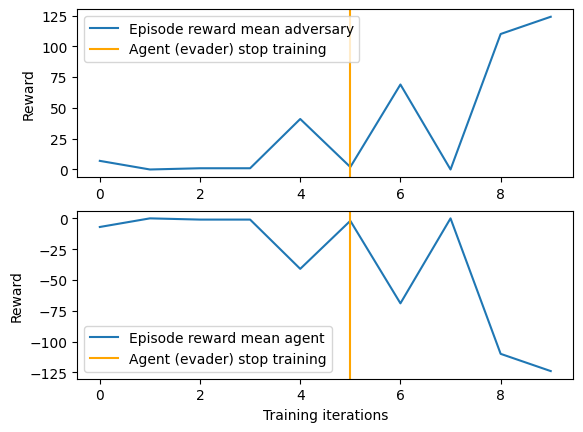

In [20]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_evaders,
        label="Agent (evader) stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

## Render

*Rendering instruction are for VMAS*, aka when running with ``use_vmas=True``.

TorchRL offers some utils to record and save rendered videos. You can learn more about these tools
`here <Environment-Recorders>`.

In the following code-block, we append a transform that will call the :meth:`render` method from the VMAS
wrapped environment and save the stack of frames to a `mp4` file which location is determined by the custom
logger `video_logger`. Note that this code may require some external dependencies such as torchvision.




In [24]:
import os

if use_vmas and not is_sphinx:
    # Replace tmpdir with any desired path where the video should be saved
    tmpdir = os.path.join(os.getcwd(), 'videos')
    os.makedirs(tmpdir, exist_ok=True)  # Ensure the directory exists
    video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
    print("Creating rendering env")
    env_with_render = TransformedEnv(env.base_env, env.transform.clone())
    env_with_render = env_with_render.append_transform(
        PixelRenderTransform(
            out_keys=["pixels"],
            # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
            preproc=lambda x: x.copy(),
            as_non_tensor=True,
            # asking for array rather than on-screen rendering
            mode="rgb_array",
        )
    )
    env_with_render = env_with_render.append_transform(
        VideoRecorder(logger=video_logger, tag="vmas_rendered")
    )
    with set_exploration_type(ExplorationType.DETERMINISTIC):
        print("Rendering rollout...")
        env_with_render.rollout(100, policy=agents_exploration_policy)
    print("Saving the video...")
    env_with_render.transform.dump()
    print("Saved! Saved directory tree:")
    video_logger.print_log_dir()

Creating rendering env
Rendering rollout...
Saving the video...


c:\Users\winds\Desktop\ML\RL\RL-Georgia Tech\.venv\Lib\site-packages\torchvision\io\_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
2025-11-10 22:12:30,374 [tensordict][INFO] Directory size: 21.60 KB
2025-11-10 22:12:30,375 [tensordict][INFO] videos/
2025-11-10 22:12:30,375 [tensordict][INFO]     vmas_logs/
2025-11-10 22:12:30,375 [tensordict][INFO]         scalars/
2025-11-10 22:12:30,376 [tensordict][INFO]         texts/
2025-11-10 22:12:30,376 [tensordict][INFO]         videos/
2025-11-10 22:12:30,377 [tensordict][INFO]             vmas_rendered_0.mp4


Saved! Saved directory tree:


## Conclusion and next steps

In this tutorial, we have seen:

- How to create a competitive multi-group multi-agent environment in TorchRL, how its specs work, and how it integrates with the library;
- How to create multi-agent network architectures in TorchRL for multiple groups;
- How we can use :class:`tensordict.TensorDict` to carry multi-agent multi-group data;
- How we can tie all the library components (collectors, modules, replay buffers, and losses) in a multi-agent multi-group MADDPG/IDDPG training loop.

Now that you are proficient with multi-agent DDPG, you can check out all the TorchRL multi-agent implementations in the
GitHub repository.
These are code-only scripts of many MARL algorithms such as the ones seen in this tutorial,
QMIX, MADDPG, IQL, and many more!

Also do remember to check out our tutorial: :doc:`/tutorials/multiagent_ppo`.

Finally, you can modify the parameters of this tutorial to try many other configurations and scenarios
to become a MARL master.

[PettingZoo](https://pettingzoo.farama.org/)_ and VMAS contain many more scenarios.
Here are a few videos of some possible scenarios you can try in VMAS.

.. figure:: https://github.com/matteobettini/vmas-media/blob/main/media/vmas_scenarios_more.gif?raw=true
   :alt: VMAS scenarios

   Scenarios available in [VMAS](https://github.com/proroklab/VectorizedMultiAgentSimulator)_


